In [1]:
!pip install hyperspy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
#from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import os
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torchvision
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import os
import h5py
# from torchsummary import summary
# import pytorch_model_summary as pms
from tqdm import tqdm
import torch.tensor as tensor
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# Download and pretrain of the data

In [18]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-03_EfVPMV8phGFQ_m7DBYrJ1-2UwUF-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-03_EfVPMV8phGFQ_m7DBYrJ1-2UwUF-" -O file.hspy && rm -rf /tmp/cookies.txt

--2021-02-16 16:34:46--  https://docs.google.com/uc?export=download&confirm=go7e&id=1-03_EfVPMV8phGFQ_m7DBYrJ1-2UwUF-
Resolving docs.google.com (docs.google.com)... 172.217.10.238, 2607:f8b0:4006:813::200e
Connecting to docs.google.com (docs.google.com)|172.217.10.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6k-docs.googleusercontent.com/docs/securesc/hrru1ug8b7i7n4euatd6rgq6n3dauf5c/c7fm51r946839uanggr4ovpjintillib/1613511225000/06270283360026920702/17137765080343969850Z/1-03_EfVPMV8phGFQ_m7DBYrJ1-2UwUF-?e=download [following]
--2021-02-16 16:34:46--  https://doc-08-6k-docs.googleusercontent.com/docs/securesc/hrru1ug8b7i7n4euatd6rgq6n3dauf5c/c7fm51r946839uanggr4ovpjintillib/1613511225000/06270283360026920702/17137765080343969850Z/1-03_EfVPMV8phGFQ_m7DBYrJ1-2UwUF-?e=download
Resolving doc-08-6k-docs.googleusercontent.com (doc-08-6k-docs.googleusercontent.com)... 172.217.12.193, 2607:f8b0:4006:81b::2001
Connecting to doc-0

In [2]:
s = hs.load("4d_TEM/file.hspy", reader="hspy", lazy=False)

In [3]:
log_data = np.log(np.log(s.data+1)+1).reshape(-1,256,256)

In [4]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
sd_pixel= scale.fit_transform(log_data.reshape(-1,256*256))

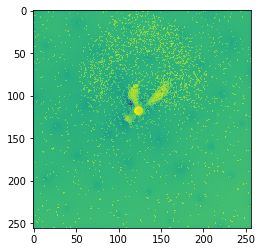

In [5]:
plt.imshow(sd_pixel[100].reshape(256,256))

In [6]:
sd_pixel_cut = sd_pixel.reshape(256,256,256,256)[50:200,50:200,:,:].reshape(-1,256,256)

# Autoencoder model

In [7]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        #self.cov1d_3 = nn.Conv2d(t_size,t_size,9,stride=3,padding=1,padding_mode = 'zeros')
#         self.attention_1 = nn.MultiheadAttention(n_step, 1)
#         self.attention_2 = nn.MultiheadAttention(n_step, 1)
#         self.attention_3 = nn.MultiheadAttention(n_step, 1)
#         self.norm_1 = nn.LayerNorm([n_step])
#         self.norm_2 = nn.LayerNorm([n_step])
        self.norm_3 = nn.LayerNorm(n_step)
#        self.drop = nn.Dropout(p=0.2)
#         self.relu_1 = nn.ReLU()
#         self.relu_2 = nn.ReLU()
#         self.relu_3 = nn.ReLU()
        self.relu_4 = nn.ReLU()
        
    def forward(self,x):
        x_input = x
#        x_k_v = x_input.transpose(0,1)
        out = self.cov1d_1(x)
#         x = self.norm_1(x)
#         x = self.relu_1(x)
#         x = x.transpose(0,1)
#         #implement self-attention layer
#         x,_ = self.attention_1(x,x_k_v,x_k_v)
#         x = x.transpose(0,1)
        
        out = self.cov1d_2(out)
#         x = self.norm_2(x)
#         x = self.relu_2(x)
#         x = x.transpose(0,1)
#         #implement self-attention layer
#         x,_ = self.attention_2(x,x_k_v,x_k_v)
#         x = x.transpose(0,1)
        
#        x = self.cov1d_3(x)
        out = self.norm_3(out)
#         x = self.relu_3(x)
#         x = x.transpose(0,1)
#         #implement self-attention layer
#         x,_ = self.attention_3(x,x_k_v,x_k_v)
#         x = x.transpose(0,1)
        
        out = self.relu_4(out)
        out = out.add(x_input)
#        output = self.drop(x)
        
        return out

In [8]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
#         self.attention_1 = nn.MultiheadAttention(n_step, 1)
        self.norm_1 = nn.LayerNorm(n_step)
#        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x_input = x
#        x_k_v = x_input.transpose(0,1)
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
#         x = x.transpose(0,1)
#         #implement self-attention layer
#         x,_ = self.attention_1(x,x_k_v,x_k_v)
#         x = x.transpose(0,1)
#        output = self.drop(x)
        
        return out

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.cov2d = nn.Conv2d(1,128,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(128,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=[256,256])
        self.conv_block_2 = conv_block(t_size=128,n_step=[64,64])
        self.conv_block_3 = conv_block(t_size=128,n_step=[16,16])
#        self.conv_block_4 = conv_block(t_size=128,n_step=32)
        self.iden_block_1 = identity_block(t_size=128,n_step=[256,256])
        self.iden_block_2 = identity_block(t_size=128,n_step=[64,64])
        self.iden_block_3 = identity_block(t_size=128,n_step=[16,16])
#        self.iden_block_4 = identity_block(t_size=128,n_step=32)
        self.relu_1 = nn.ReLU()
#         self.relu_2 = nn.ReLU()
#         self.relu_3 = nn.ReLU()
#        self.average = nn.AvgPool2d(2,stride=2)
        self.maxpool_1 = nn.MaxPool2d(4,stride=4)
        self.maxpool_2 = nn.MaxPool2d(4,stride=4)
        self.maxpool_3 = nn.MaxPool2d(2,stride=2)
#        self.maxpool_4 = nn.MaxPool2d(2,stride=2)
#        self.lstm = nn.LSTM(1,125,batch_first=True,bidirectional=True)
        self.dense = nn.Linear(64,64)
#        self.mn = nn.Linear(25,25)
#        self.sd = nn.Linear(25,25)
#        self.logspike = nn.Linear(32,8)
        
    def forward(self,x):
#        x = x.transpose(1,2)
        x = x.view(-1,1,256,256)
#        x = self.average(x)
        x = self.cov2d(x)
        x = self.iden_block_1(x)
        x = self.conv_block_1(x)
        x = self.maxpool_1(x)
        x = self.iden_block_2(x)
        x = self.conv_block_2(x)
        x = self.maxpool_2(x)
        x = self.iden_block_3(x)
        x = self.conv_block_3(x)
        x = self.maxpool_3(x)
#         x = self.iden_block_4(x)
#         x = self.conv_block_4(x)
#         x = self.maxpool_4(x)
        x = self.cov2d_1(x)
        x = torch.flatten(x,start_dim=1)
#        print(x.shape)
#         x = x.transpose(1,2)
#        encode,(_,__) = self.lstm(x)
#        encode = encode[:,-1,:]
        selection = self.dense(x)    
        selection = self.relu_1(selection)
        return selection

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.cov2d = nn.Conv2d(128,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.conv_block_1 = conv_block(t_size=128,n_step=[8,8])
        self.conv_block_2 = conv_block(t_size=128,n_step=[16,16])
        self.conv_block_3 = conv_block(t_size=128,n_step=[64,64])
        self.conv_block_4 = conv_block(t_size=128,n_step=[256,256])
#        self.conv_block_5 = conv_block(t_size=128,n_step=128)
        self.iden_block_1 = identity_block(t_size=128,n_step=[8,8])
        self.iden_block_2 = identity_block(t_size=128,n_step=[16,16])
        self.iden_block_3 = identity_block(t_size=128,n_step=[64,64])
        self.iden_block_4 = identity_block(t_size=128,n_step=[256,256])
#        self.iden_block_5 = identity_block(t_size=128,n_step=[150,180])
        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample_2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample_3 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
#        self.upsample_4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        
    def forward(self,x):
 #       x = x[:,:,None]
        x = x.view(-1,1,8,8)
#        x = x.transpose(1,2)
        x = x.repeat([1,128,1,1])
        x = self.iden_block_1(x)
        x = self.conv_block_1(x)
        x = self.upsample_1(x)
        x = self.iden_block_2(x)
        x = self.conv_block_2(x)
        x = self.upsample_2(x)
        x = self.iden_block_3(x)
        x = self.conv_block_3(x)
        x = self.upsample_3(x)
        x = self.iden_block_4(x)
        x = self.conv_block_4(x)
#         x = self.upsample_4(x)
#         x = self.iden_block_5(x)
#         x = self.conv_block_5(x)
        x = self.cov2d(x)
#        x = x.transpose(1,2)
        x = x.view(-1,256,256)
        
        return x

In [11]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''

    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        embedding= self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize

        # decode
        predicted = self.dec(embedding)
        
        return predicted

In [12]:
device = 'cuda'

In [13]:
class Entropy_Loss(nn.Module):
    def __init__(self, entroy_coe):
        super(Entropy_Loss, self).__init__()
        self.coe = entroy_coe

    def to(self, device):
        self.device = device
        super().to(device)
        return self

    def forward(self, x):
        en_loss = self.entropy_loss(x)
        return en_loss

    def entropy_loss(self, embedding):
        N = embedding.shape[1]
        N = torch.tensor(N).type(torch.float32)
        mask = embedding != 0
        mask1 = torch.sum(mask, axis=0)
        mask2 = mask1 != 0
        n = torch.sum(mask2).type(torch.float32)
        loss_min = (N // 2 + 1).lgamma().exp() ** 2 / (N + 1).lgamma().exp()
        loss = (N - n + 1).lgamma().exp() * (n + 1).lgamma().exp() / (N + 1).lgamma().exp()
        loss = loss - loss_min

        return self.coe * loss

In [14]:
class Regularization(nn.Module):
    def __init__(self, model, weight_decay, p=2):
        '''
        :param model
        :param weight_decay: coeifficient of 
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        '''
        super(Regularization, self).__init__()
        if weight_decay < 0:
            print("param weight_decay can not <0")
            exit(0)
        self.model = model
        self.weight_decay = weight_decay
        self.p = p
        self.weight_list = self.get_weight(model)

    #       self.weight_info(self.weight_list)

    def to(self, device):
        '''
        :param device: cude or cpu
        :return:
        '''
        self.device = device
        super().to(device)
        return self

    def forward(self, model):
        self.weight_list = self.get_weight(model)  
        reg_loss = self.regularization_loss(self.weight_list, self.weight_decay, p=self.p)
        return reg_loss

    def get_weight(self, model):
        '''
        :param model: model
        :return: list of layers needs to be regularized  
        '''
        weight_list = []
        for name, param in model.named_parameters():
            if 'dec' in name and 'weight' in name:
                weight = (name, param)
                weight_list.append(weight)
        return weight_list

    def regularization_loss(self, weight_list, weight_decay, p):
        '''
        :param weight_list: list of layers needs to be regularized  
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        :param weight_decay: coeifficient
        :return: loss
        '''
        # weight_decay=Variable(torch.FloatTensor([weight_decay]).to(self.device),requires_grad=True)
        # reg_loss=Variable(torch.FloatTensor([0.]).to(self.device),requires_grad=True)
        # weight_decay=torch.FloatTensor([weight_decay]).to(self.device)
        # reg_loss=torch.FloatTensor([0.]).to(self.device)
        reg_loss = 0
        for name, w in weight_list:
            l2_reg = torch.norm(w, p=p)
            reg_loss = reg_loss + l2_reg

        reg_loss = weight_decay * reg_loss
        return reg_loss

    def weight_info(self, weight_list):
        '''
        :param weight_list:
        :return: list of layers' name needs to be regularized  
        '''
        print("---------------regularization weight---------------")
        for name, w in weight_list:
            print(name)

In [15]:
def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  coef = 0, 
                  coef1 = 0,
                  ln_parm = 1, 
                  beta = None):

    weight_decay = coef
    weight_decay_1 = coef1

    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
    #    for i, x in enumerate(train_iterator):
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):

        
        reg_loss_2 = Regularization(model, weight_decay_1, p=2).to(device)
     

        x = x.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()

        if beta is None: 
        
          embedding = encoder(x)
        
        else:
        
          # forward pass
          #        predicted_x = model(x)
          embedding,sd,mn = encoder(x)
        
        if weight_decay > 0:
            reg_loss_1 = weight_decay * torch.norm(embedding, ln_parm).to(device)
        else:
            reg_loss_1 = 0.0 

        predicted_x = decoder(embedding)

        # reconstruction loss
        loss = F.mse_loss(x, predicted_x, reduction='mean')

        
        loss = loss +  reg_loss_1 #+reg_loss_2(model) 
            
        if beta is not None:
            vae_loss = beta * 0.5 * torch.sum(torch.exp(sd) + (mn)**2 - 1.0 - sd).to(device)
            vae_loss/= (sd.shape[0]*sd.shape[1])
        else:
            vae_loss=0

        loss = loss + vae_loss
        
        # backward pass
        train_loss += loss.item()

        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

In [43]:
def Train(model,encoder,decoder,train_iterator,optimizer,
          epochs, coef=0,coef_1=0,ln_parm=1, beta=None):
    
    N_EPOCHS = epochs
    best_train_loss = float('inf')
    
    for epoch in range(N_EPOCHS):

        train = loss_function(model,encoder,decoder,train_iterator,
                              optimizer,coef,coef_1,ln_parm,beta)
        train_loss = train
        train_loss /= len(train_iterator)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')
        print('.............................')

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(), 
                'decoder': decoder.state_dict()
            }
            if epoch >=1:
                torch.save(checkpoint, f'4d_TEM/log_log_cut_pixel_sd_l1=1e-4.pkl')

In [16]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Trian the data

In [17]:
train_iterator = DataLoader(sd_pixel_cut, batch_size=30,
                        shuffle=True)

In [47]:
Train(model,encoder,decoder,train_iterator,optimizer,2000,coef=1e-4)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.7556
.............................


100%|██████████| 750/750 [23:31<00:00,  1.88s/it]


Epoch 1, Train Loss: 0.7309
.............................


100%|██████████| 750/750 [23:30<00:00,  1.88s/it]


Epoch 2, Train Loss: 0.7266
.............................


100%|██████████| 750/750 [23:29<00:00,  1.88s/it]


Epoch 3, Train Loss: 0.7243
.............................


100%|██████████| 750/750 [20:21<00:00,  1.63s/it]


Epoch 4, Train Loss: 0.7228
.............................


100%|██████████| 750/750 [12:34<00:00,  1.01s/it]


Epoch 5, Train Loss: 0.7217
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 6, Train Loss: 0.7208
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 7, Train Loss: 0.7202
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 8, Train Loss: 0.7196
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 9, Train Loss: 0.7191
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 10, Train Loss: 0.7187
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 11, Train Loss: 0.7183
.............................


 86%|████████▌ | 642/750 [10:44<01:48,  1.00s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 23, Train Loss: 0.7160
.............................


100%|██████████| 750/750 [12:32<00:00,  1.00s/it]


Epoch 24, Train Loss: 0.7159
.............................


100%|██████████| 750/750 [12:32<00:00,  1.00s/it]


Epoch 25, Train Loss: 0.7157
.............................


100%|██████████| 750/750 [12:32<00:00,  1.00s/it]


Epoch 26, Train Loss: 0.7157
.............................


 54%|█████▎    | 402/750 [06:43<05:49,  1.00s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 37, Train Loss: 0.7149
.............................


100%|██████████| 750/750 [12:32<00:00,  1.00s/it]


Epoch 38, Train Loss: 0.7148
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 39, Train Loss: 0.7147
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 40, Train Loss: 0.7147
.............................


 13%|█▎        | 100/750 [01:40<10:52,  1.00s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 50, Train Loss: 0.7143
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 51, Train Loss: 0.7142
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 52, Train Loss: 0.7142
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 53, Train Loss: 0.7143
.............................


 61%|██████    | 457/750 [07:39<04:54,  1.00s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 65, Train Loss: 0.7139
.............................


100%|██████████| 750/750 [12:33<00:00,  1.01s/it]


Epoch 66, Train Loss: 0.7138
.............................


100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 67, Train Loss: 0.7138
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 68, Train Loss: 0.7138
.............................


 19%|█▉        | 143/750 [02:23<10:10,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 78, Train Loss: 0.7136
.............................


100%|██████████| 750/750 [12:33<00:00,  1.01s/it]


Epoch 79, Train Loss: 0.7135
.............................


 77%|███████▋  | 580/750 [09:42<02:50,  1.00s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:33<00:00,  1.00s/it]


Epoch 82, Train Loss: 0.7135
.............................


 65%|██████▌   | 489/750 [08:11<04:22,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 92, Train Loss: 0.7134
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 93, Train Loss: 0.7134
.............................


100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 94, Train Loss: 0.7133
.............................


 33%|███▎      | 245/750 [04:06<08:29,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 96, Train Loss: 0.7133
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 97, Train Loss: 0.7133
.............................


 18%|█▊        | 135/750 [02:16<10:20,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 106, Train Loss: 0.7132
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 107, Train Loss: 0.7132
.............................


 41%|████▏     | 311/750 [05:13<07:22,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 109, Train Loss: 0.7132
.............................


 96%|█████████▌| 717/750 [12:03<00:33,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 120, Train Loss: 0.7130
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 121, Train Loss: 0.7130
.............................


 99%|█████████▉| 742/750 [12:27<00:08,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 124, Train Loss: 0.7130
.............................


 49%|████▉     | 369/750 [06:11<06:24,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 134, Train Loss: 0.7129
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 135, Train Loss: 0.7129
.............................


100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 136, Train Loss: 0.7129
.............................


 62%|██████▏   | 468/750 [07:51<04:44,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 138, Train Loss: 0.7129
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 139, Train Loss: 0.7129
.............................


 18%|█▊        | 133/750 [02:14<10:21,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 147, Train Loss: 0.7128
.............................


100%|██████████| 750/750 [12:35<00:00,  1.01s/it]


Epoch 148, Train Loss: 0.7128
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 149, Train Loss: 0.7128
.............................


 58%|█████▊    | 436/750 [07:19<05:16,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 151, Train Loss: 0.7128
.............................


 66%|██████▋   | 497/750 [08:20<04:15,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 162, Train Loss: 0.7127
.............................


100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 163, Train Loss: 0.7127
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 164, Train Loss: 0.7127
.............................


 24%|██▍       | 179/750 [03:00<09:35,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 166, Train Loss: 0.7127
.............................


 26%|██▋       | 197/750 [03:18<09:17,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 176, Train Loss: 0.7126
.............................


100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 177, Train Loss: 0.7126
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 178, Train Loss: 0.7126
.............................


 87%|████████▋ | 650/750 [10:55<01:40,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 699/750 [11:45<00:51,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 191, Train Loss: 0.7125
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 192, Train Loss: 0.7125
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 193, Train Loss: 0.7125
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 194, Train Loss: 0.7125
.............................


 42%|████▏     | 316/750 [05:18<07:17,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:36<00:00,  1.01s/it]


Epoch 204, Train Loss: 0.7125
.............................


  0%|          | 0/750 [00:00<?, ?it/s]

Epoch 205, Train Loss: 0.7125
.............................


 26%|██▋       | 197/750 [03:18<09:18,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:37<00:00,  1.01s/it]


Epoch 208, Train Loss: 0.7125
.............................


100%|██████████| 750/750 [12:37<00:00,  1.01s/it]


Epoch 209, Train Loss: 0.7124
.............................


 14%|█▍        | 108/750 [01:48<10:48,  1.01s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 750/750 [12:39<00:00,  1.01s/it]


Epoch 212, Train Loss: 0.7124
.............................


100%|██████████| 750/750 [12:37<00:00,  1.01s/it]


Epoch 213, Train Loss: 0.7124
.............................


100%|██████████| 750/750 [12:37<00:00,  1.01s/it]


Epoch 214, Train Loss: 0.7124
.............................


 74%|███████▍  | 558/750 [09:22<03:13,  1.01s/it]


KeyboardInterrupt: 

# Load the model weights

In [18]:
path_checkpoint = "4d_TEM/log_log_cut_pixel_sd_l1=1e-4.pkl"

checkpoint = torch.load(path_checkpoint)  # 加载断点

model.load_state_dict(checkpoint['net'])# 加载模型可学习参数
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
start_epoch = checkpoint['epoch'] 

# Show the embedding and reconstruction

In [20]:
train_iterator = DataLoader(sd_pixel_cut, batch_size=50,
                        shuffle=False)

In [21]:
embedding_ = np.zeros([22500,64])
result_ = np.zeros([22500,256,256])
j = 0
for i, x in enumerate(train_iterator):
    with torch.no_grad():
        value = x
        test_value = Variable(value.cuda())
        test_value = test_value.float()
        #    result,a,b,c = model(test_value)
        result = model(test_value)
        result1 = result.cpu()
        #    mn,st,log,embedding = encoder(test_value)

        result1 = result1.detach().numpy()
#        print(np.mean(result1))
        result_[i*50:(i+1)*50]=result1
        #     result1 = result1.reshape(784,1000,1)
        embedding = encoder(test_value)
        embedding1 = embedding.to('cpu')
        embedding1 = embedding1.detach().numpy()
#        embedding1 = embedding1.reshape(64,64)
#        print(np.mean(embedding1))
        embedding_[i*50:(i+1)*50,:] = embedding1
        print(i)
        j=j+1
print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1
2
3
9
11
12
14
20
21
22
26
31
41
47
49
52
57
58
59


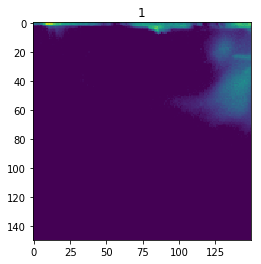

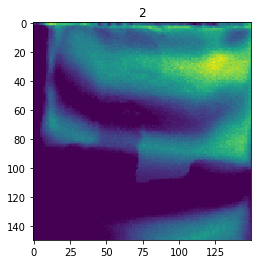

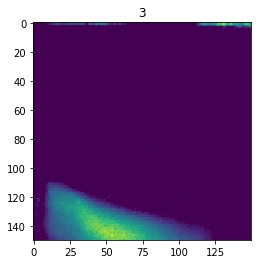

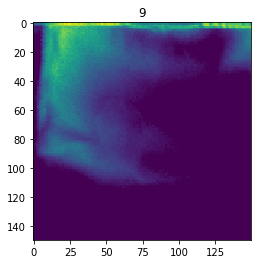

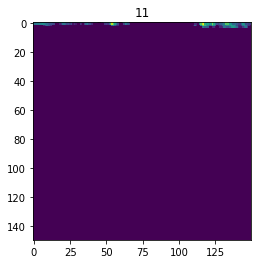

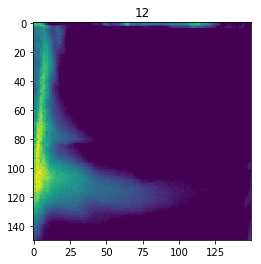

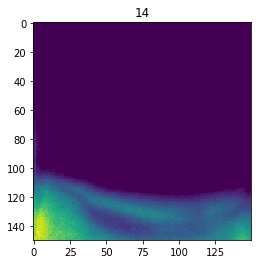

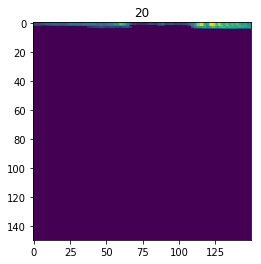

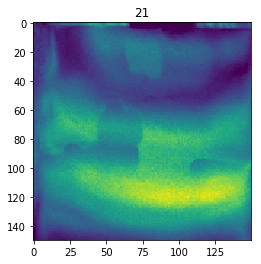

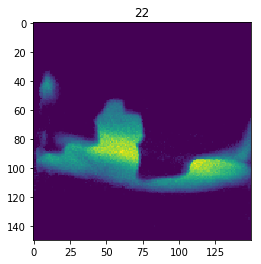

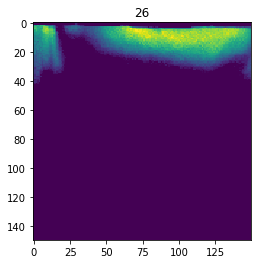

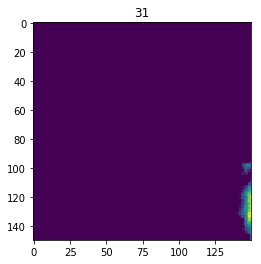

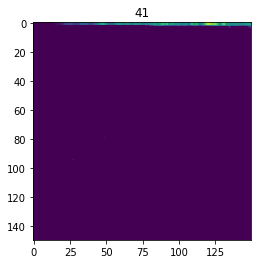

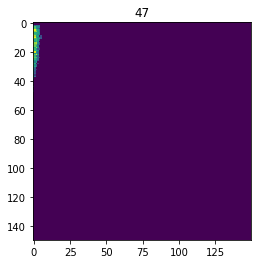

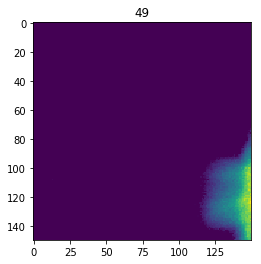

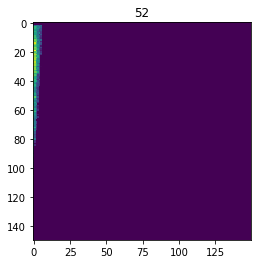

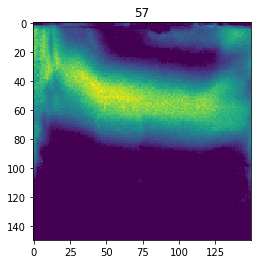

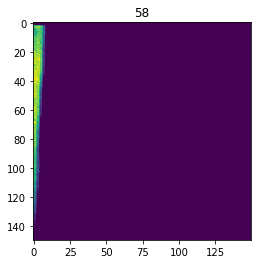

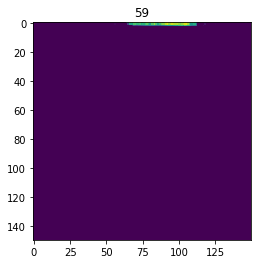

In [25]:
# log_log_cut_pixel_sd_l1=1e-4
for i in range(64):
    if np.sum(embedding_[:,i])>0:
        print(i)
        plt.figure()
        plt.title(str(i))
        plt.imshow(embedding_[:,i].reshape(150,150))

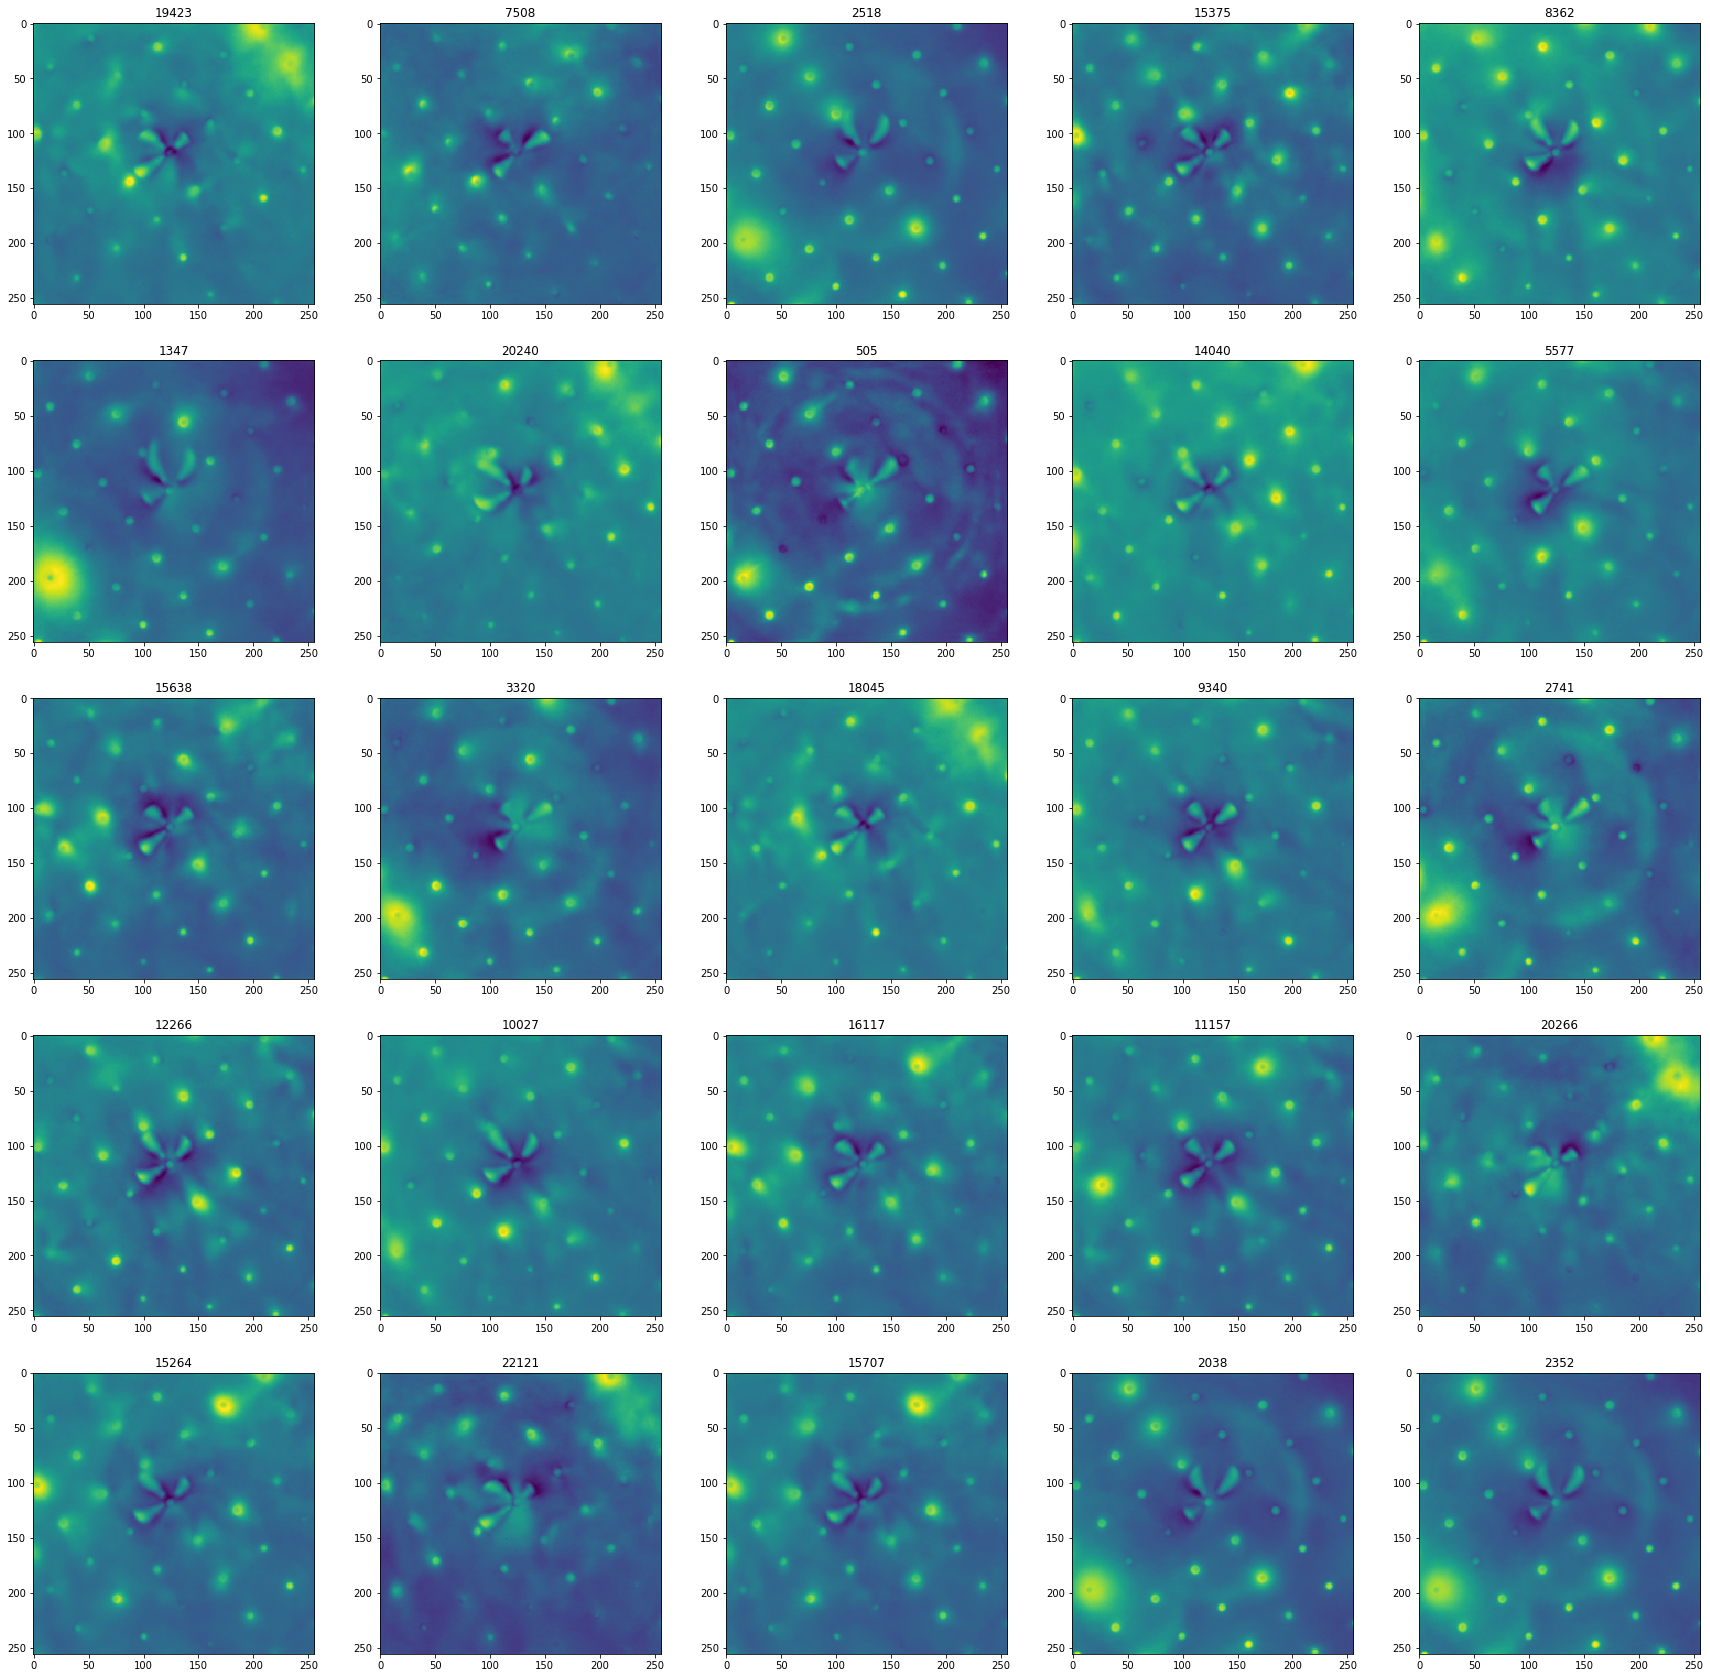

In [32]:
#log_log_cut_pixel_sd_l1=1e-4
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, 22500)
#        print(k)
        ax = axs[i,j]
        #ax.plot(f_y5[k],'r-')
#        ax.imshow(log_data_small[k]-result_[k],clim=[0,1])
        ax.set_title(np.str(k))
        ax.imshow(result_[k])

In [12]:
from skimage.transform import radon, iradon

In [13]:
from sklearn.preprocessing  import StandardScaler

# Generating the Generator 

In [51]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}


class generator:
    
    def __init__(self, 
                 model,
                 scaled_data,
                 embedding_out,
                 image, 
                 channels = None,
                 color_map = 'viridis'):
        
        self.model = model
        self.image = image
        
        # defines the colorlist
        self.cmap = plt.get_cmap(color_map)
        
        
#         if isinstance(model, type(DictionaryLearning())): 
#             def predictor(values): 
#                 return np.dot(values, model.components_)
#             self.predict = predictor
#             self.vector_length = scaled_data.shape[1]
#             self.embeddings = model.transform(scaled_data)
            
            
#         elif isinstance(model,type(model_builder(np.atleast_3d(scaled_data)))):
#             def predictor(values): 
#                 return model.decoder_model.predict(np.atleast_2d(values))
#             self.embeddings = model.encoder_model.predict(np.atleast_3d(scaled_data))
#             self.predict = predictor
#             self.vector_length = scaled_data.shape[1]
            
#         else:
#             raise Exception('The model is not an included model type '.format(dictonary_model))
            
        def predictor(values): 
                values = torch.from_numpy(np.atleast_2d(values))
                values = model(values.float())
                values = values.detach().numpy()
                
                return values
            
        self.embeddings = embedding_out
        self.predict = predictor
        self.vector_length = scaled_data.shape[1]
        if channels == None:
            self.channels = range(self.embeddings.shape[1])
        else: 
            self.channels = channels
        

    def generator_images(self, 
                        folder, 
                        ranges = None,
                        number_of_loops = 200, 
                        averaging_number = 100,
                        graph_layout = [4,4], 
                        y_lim = [-2,12],
                        xlabel = '',
                        ylabel = '',
                        xvalues = None,
                        in_radon=False
                        ):
        
        folder = make_folder(folder)
        
        for i in tqdm(range(number_of_loops)):

            # builds the figure
            fig, ax = plt.subplots(graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0), graph_layout[1],
                                   figsize=(3 * graph_layout[1], 3 * (graph_layout[0] // graph_layout[1] + (graph_layout[0] % graph_layout[1] > 0))))
            ax = ax.reshape(-1)

            # loops around all of the embeddings
            for j, channel  in enumerate(self.channels):
                
                # checks if the value is None and if so skips tp next iteration
                if i is None:
                    continue
                    
                if xvalues is None:
                    xvalues = range(self.vector_length)
                
                if ranges is None: 
                    ranges =  np.stack((np.min(self.embeddings,axis=0),
                              np.max(self.embeddings,axis=0)), axis=1)

                # linear space values for the embeddings
                value = np.linspace(ranges[channel][0], ranges[channel][1], 
                                    number_of_loops)

                # finds the nearest point to the value and then takes the average
                # average number of points based on the averaging number
                idx = find_nearest(
                    self.embeddings[:,channel], 
                    value[i], 
                    averaging_number)
                
                # computes the mean of the selected index
                gen_value = np.mean(self.embeddings[idx], axis=0)
                
                # specifically updates the value of the embedding to visualize based on the
                # linear spaced vector
                gen_value[channel] = value[i]

                # generates the loop based on the model
                generated = self.predict(gen_value).squeeze()

                # plots the graph
   #             ax[j].imshow(generated, color=self.cmap((i + 1) / number_of_loops))
                if in_radon==True:
                    generated = iradon(generated)
        
                ax[j].imshow(generated)

                # formats the graph
   #             ax[j].set_ylim(y_lim[0],y_lim[1])
   #             ax[j].set_yticklabels('')
                ax[j].set_xlabel(xlabel)

                # gets the position of the axis on the figure
                pos = ax[j].get_position()

                # plots and formats the binary cluster map
                axes_in = plt.axes([pos.x0-0.18 , pos.y1, .12 * 4, .12 * 4])

                ## rotates the figure
                #if plot_format['rotation']:
                #    imageb, scalefactor = rotate_and_crop(embeddings[:, j].reshape(image.shape),
                #                                          angle=plot_format['angle'], frac_rm=plot_format['frac_rm'])
                #else:
                #    scalefactor = 1
                #    imageb = encode_small[:, j].reshape(60, 60)

                # plots the imagemap and formats
                axes_in.imshow(self.embeddings[:, channel].reshape(self.image.shape[0:2]), clim=ranges[channel])
                axes_in.set_yticklabels('')
                axes_in.set_xticklabels('')

            ax[0].set_ylabel(ylabel)

            savefig(pjoin(folder, f'{i:04d}_maps'), printing)
            plt.close(fig)

In [52]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [53]:
def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

In [54]:
def savefig(filename, printing):

    """
    function that saves the figure

    :param filename: path to save file
    :type filename: string
    :param printing: contains information for printing
                     'dpi': int
                            resolution of exported image
                      print_EPS : bool
                            selects if export the EPS
                      print_PNG : bool
                            selects if print the PNG
    :type printing: dictionary

    """


    # Saves figures at EPS
    if printing['EPS']:
        plt.savefig(filename + '.eps', format='eps',
                    dpi=printing['dpi'], bbox_inches='tight')

    # Saves figures as PNG
    if printing['PNG']:
        plt.savefig(filename + '.png', format='png',
                    dpi=printing['dpi'], bbox_inches='tight')

In [55]:
def layout_fig(graph, mod=None):
    """
    Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    Parameters
    ----------
    graphs : int
        number of axes to make
    mod : int (optional)
        sets the number of figures per row
    Returns
    -------
    fig : matplotlib figure
        handel to figure being created.
    axes : numpy array (axes)
        numpy array of axes that are created.
    """
    print(graph)

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
       
    mod = graph//2
            
    mod =int(mod)
    graph = int(graph)

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    # deletes extra unneeded axes
    axes = axes.reshape(-1)
    for i in range(axes.shape[0]):
        if i + 1 > graph:
            fig.delaxes(axes[i])

    return (fig, axes)

In [56]:
from tqdm import tqdm
from os.path import join as pjoin

In [57]:
import glob as glob
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip


def make_movie(movie_name, input_folder, output_folder, file_format,
                            fps, output_format = 'mp4', reverse = False):

    """
    Function which makes movies from an image series

    Parameters
    ----------
    movie_name : string
        name of the movie
    input_folder  : string
        folder where the image series is located
    output_folder  : string
        folder where the movie will be saved
    file_format  : string
        sets the format of the files to import
    fps  : numpy, int
        frames per second
    output_format  : string, optional
        sets the format for the output file
        supported types .mp4 and gif
        animated gif create large files
    reverse : bool, optional
        sets if the movie will be one way of there and back
    """

    # searches the folder and finds the files
    file_list = glob.glob('./' + input_folder + '/*.' + file_format)

    # Sorts the files by number makes 2 lists to go forward and back
    list.sort(file_list)
    file_list_rev = glob.glob('./' + input_folder + '/*.' + file_format)
    list.sort(file_list_rev,reverse=True)

    # combines the file list if including the reverse
    if reverse:
        new_list = file_list + file_list_rev
    else:
        new_list = file_list


    if output_format == 'gif':
        # makes an animated gif from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_gif(output_folder + '/{}.gif'.format(movie_name), fps=fps)
    else:
        # makes and mp4 from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_videofile(output_folder + '/{}.mp4'.format(movie_name), fps=fps)

In [58]:
image = np.zeros([150,150])

In [60]:
ranges=[2,21,22,57]

In [61]:
generator_4d_maker = generator(decoder,image,embedding_, 
                                image, channels=ranges)

In [62]:
decoder.to('cpu')

Decoder(
  (cov2d): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_block_1): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_3): LayerNorm((8, 8), eps=1e-05, elementwise_affine=True)
    (relu_4): ReLU()
  )
  (conv_block_2): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_3): LayerNorm((16, 16), eps=1e-05, elementwise_affine=True)
    (relu_4): ReLU()
  )
  (conv_block_3): conv_block(
    (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_3): LayerNorm((64, 64), eps=1e-05, elementwise_affine=True)
    (relu_4): ReLU()
  )
  (conv_block_4): conv_block(
    (cov1d_1)

In [63]:
generator_4d_maker.generator_images(folder = '4d_TEM/log_log_cut_1e-4_movie/', 
                                 number_of_loops=200)

100%|██████████| 200/200 [05:21<00:00,  1.61s/it]


In [64]:
make_movie('log_log_cut_1e-4_movie',
           '4d_TEM/log_log_cut_1e-4_movie',
           '4d_TEM/log_log_cut_1e-4_movie',
          'png',
          3)

Moviepy - Building video 4d_TEM/log_log_cut_1e-4_movie/log_log_cut_1e-4_movie.mp4.
Moviepy - Writing video 4d_TEM/log_log_cut_1e-4_movie/log_log_cut_1e-4_movie.mp4



Moviepy - Done !
Moviepy - video ready 4d_TEM/log_log_cut_1e-4_movie/log_log_cut_1e-4_movie.mp4
